In [1]:
import graphlab as gl
# Set product key on this computer. After running this cell, you will not need to re-enter your product key. 
gl.product_key.set_product_key('E58F-9A31-501B-14E4-FDFC-8D36-79A1-FF73')

# Limit number of worker processes. This preserves system memory, which prevents hosted notebooks from crashing.
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 4)

# Output active product key.
gl.product_key.get_product_key()

ImportError: No module named pkg_resources

## Load the Data from CSV File...

This is a dataset from Philadelphia related to housing. Let's check it out...

In [2]:
sales = gl.SFrame.read_csv('Philadelphia_Crime_Rate_noNA.csv')

NameError: name 'gl' is not defined

In [3]:
sales.head()

HousePrice,"HsPrc ($10,000)",CrimeRate,MilesPhila,PopChg,Name,County
140463,14.0463,29.7,10.0,-1.0,Abington,Montgome
113033,11.3033,24.1,18.0,4.0,Ambler,Montgome
124186,12.4186,19.5,25.0,8.0,Aston,Delaware
110490,11.049,49.4,25.0,2.7,Bensalem,Bucks
79124,7.9124,54.1,19.0,3.9,Bristol B.,Bucks
92634,9.2634,48.6,20.0,0.6,Bristol T.,Bucks
89246,8.9246,30.8,15.0,-2.6,Brookhaven,Delaware
195145,19.5145,10.8,20.0,-3.5,Bryn Athyn,Montgome
297342,29.7342,20.2,14.0,0.6,Bryn Mawr,Montgome
264298,26.4298,20.4,26.0,6.0,Buckingham,Bucks


It looks like its comparing House Prices to Crimerates, population change, Distance from City of Philadelphia, county and I think name of current owner...

## Explore the Data from a High Level...

In [4]:
gl.canvas.set_target('ipynb')
sales.show(view='Scatter Plot', x ='CrimeRate', y = 'HousePrice')

This dataset is a bit shit! All the values are skewed between the 0 - 100 CrimeRate range (even then, its a bit skewed to the lower side) Obviously nobody wants to live in a 400 CrimeRate Area, but we can get House Prices for that, can't we? 

## Create Linear Regression Model from Dataset...

In [5]:
crime_model = gl.linear_regression.create(sales, target='HousePrice', features=['CrimeRate'])

Linear regression:

--------------------------------------------------------

Number of examples          : 99

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 1.003365     | 314982.574662      | 83468.940148  |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

## Let's see what the Best Fit looks like...

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

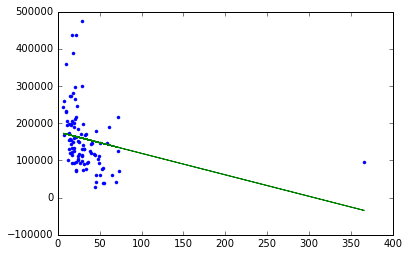

In [7]:
plt.plot(sales['CrimeRate'], sales['HousePrice'], '.',
         sales['CrimeRate'], crime_model.predict(sales), '-')

As in the Scatterplot above, Blue Dots ars the Original Dataset, Green Line is the Fitted Dataset resulting from the Crime_Model Prediction...

So, while the fit makes intuitive sense (the higher the crime rate, the lower the house price) the observation at the far right of the graph, appears to be having an effect on the overall skew of the line. That house looks like its in a very high crime rate area, but the price is significantly higher that our prediction.

Turns out, that observation is from Center City! Very High crime rates but a mixture of Low and High priced houses since its smack in the middle of town. This will definitely skew the analysis.

## Remove Center City and Redo the Analysis...

In [8]:
sales_noCC = sales[sales['MilesPhila'] != 0.0]
sales_noCC.show(view='Scatter Plot', x = 'CrimeRate', y = 'HousePrice')

So this is a much more useful distribution of datapoints. It is, however, covereing a much smaller range of crime rates (the only situation I can think of where its a bad thing)

## Create Linear Regression Model on New Dataset...

In [9]:
crime_model_noCC = gl.linear_regression.create(sales_noCC, target='HousePrice', features=['CrimeRate'])

Linear regression:

--------------------------------------------------------

Number of examples          : 98

Number of features          : 1

## Let's see how well the predictions work this time...

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.000405     | 315335.534886      | 78052.676125  |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

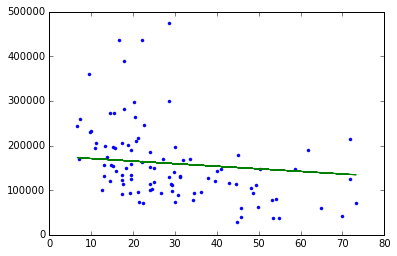

In [10]:
plt.plot(sales_noCC['CrimeRate'], sales_noCC['HousePrice'], '.',
         sales_noCC['CrimeRate'], crime_model.predict(sales_noCC), '-') #why the fuck did she use this model?!!

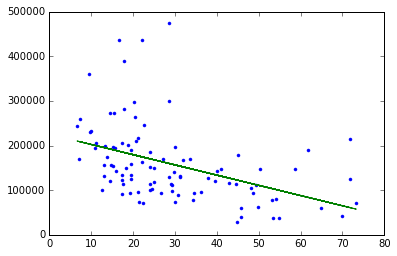

In [11]:
plt.plot(sales_noCC['CrimeRate'], sales_noCC['HousePrice'], '.',
         sales_noCC['CrimeRate'], crime_model_noCC.predict(sales_noCC), '-')

## This is getting confusing. Let's actually compare the coefficients between the two models and see which one is more useful...

In [12]:
crime_model.get('coefficients')

name,index,value,stderr
(intercept),None,176626.046881,11245.5882194
CrimeRate,None,-576.804949058,226.90225951


What this says is that the average House Value Decreases by roughly 576USD per Unit Increase in Crime Rate...

In [13]:
crime_model_noCC.get('coefficients')

name,index,value,stderr
(intercept),None,225204.604303,16404.0247514
CrimeRate,None,-2287.69717443,491.537478123


This model says that average house value decreases by roughly 2287USD per unit increase in crime rate...

By removing a single observation, the difference in the rate of decrease is huge! This is evidence of the effect of a High Leverage Point. Basically these are outliers on the X-Axis (i.e. the Input/Feature) that have the potential to change the "Center of Mass" of the best fit line...

This doesn't mean it should be automatically discounted. Even if you have such an outlier, if it complies to the general trends within the rest of the data it may not have any influence at all. Also, this applies equally to Y-Axis observations that may also skew the line. These are called Influential Observations.

## Remove High Value Neighbourhoods and Redo Analysis...

Based on the discussion above, we'll remove these super high value neighbourhoods as they are potentially skewing our analysis...

In [14]:
sales_noHighEnd = sales_noCC[sales_noCC['HousePrice'] < 350000]
sales_noHighEnd.show(view = 'Scatter Plot', x = 'CrimeRate', y = 'HousePrice')

In [15]:
crime_model_noHighEnd = gl.linear_regression.create(sales_noHighEnd, target='HousePrice', features=['CrimeRate'])

Linear regression:

--------------------------------------------------------

Number of examples          : 93

Number of features          : 1

## Let's compare the coefficients to see if they've changed much...

In [16]:
crime_model_noCC.get('coefficients')

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.000516     | 153105.996748      | 54958.023447  |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

name,index,value,stderr
(intercept),None,225204.604303,16404.0247514
CrimeRate,None,-2287.69717443,491.537478123


In [17]:
crime_model_noHighEnd.get('coefficients')

name,index,value,stderr
(intercept),None,199073.589615,11932.5101105
CrimeRate,None,-1837.71280989,351.519609333


Interesting. So there is Some Influence on the slope, but nowhere near as much as the Center City observation.

# Assignment Stuff

In [27]:
sales = gl.SFrame('kc_house_data.gl/')
sales.show(view = 'Scatter Plot', x = 'sqft_living', y = 'price')

In [47]:
sales.head()

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
7129300520,2014-10-13 00:00:00+00:00,221900.0,3.0,1.0,1180.0,5650,1,0
6414100192,2014-12-09 00:00:00+00:00,538000.0,3.0,2.25,2570.0,7242,2,0
5631500400,2015-02-25 00:00:00+00:00,180000.0,2.0,1.0,770.0,10000,1,0
2487200875,2014-12-09 00:00:00+00:00,604000.0,4.0,3.0,1960.0,5000,1,0
1954400510,2015-02-18 00:00:00+00:00,510000.0,3.0,2.0,1680.0,8080,1,0
7237550310,2014-05-12 00:00:00+00:00,1225000.0,4.0,4.5,5420.0,101930,1,0
1321400060,2014-06-27 00:00:00+00:00,257500.0,3.0,2.25,1715.0,6819,2,0
2008000270,2015-01-15 00:00:00+00:00,291850.0,3.0,1.5,1060.0,9711,1,0
2414600126,2015-04-15 00:00:00+00:00,229500.0,3.0,1.0,1780.0,7470,1,0
3793500160,2015-03-12 00:00:00+00:00,323000.0,3.0,2.5,1890.0,6560,2,0


In [19]:
tr_data, ts_data = sales.random_split(0.8, seed = 0)

In [32]:
def simple_linear_regression(input_feature, output):
    # compute the mean of input_feature and output
    mean_input = input_feature.mean()
    mean_output = output.mean()
    
    # compute the product of the output and the input_feature and its mean
    mean_input_output= (input_feature * output).mean()
    
    # compute the squared value of the input_feature and its mean
    mean_input_sqrd = (input_feature * input_feature).mean()
    
    # use the formula for the slope
    numerator = mean_input_output - (mean_input * mean_output)
    denominator = mean_input_sqrd - (mean_input * mean_input)
    slope = numerator / denominator
    
    # use the formula for the intercept
    intercept = mean_output - (slope * mean_input)
    
    return(intercept, slope)

Fixed Input and output to test if the function actually works. Output should be 1.0. Copied the code wholesale...

In [34]:
test_feature = gl.SArray(range(5))
test_output = gl.SArray(1 + 1*test_feature)
(test_intercept, test_slope) =  simple_linear_regression(test_feature, test_output)

print "Intercept> {}".format(str(test_intercept))
print "Slope> {}".format(str(test_slope))

Intercept> 1.0
Slope> 1.0


Looks like the function works. Let's run it on actual data...

In [48]:
sqft_intercept, sqft_slope = simple_linear_regression(tr_data['sqft_living'], tr_data['price'])

print "Intercept> {}".format(str(sqft_intercept))
print "Slope> {}".format(str(sqft_slope))

Intercept> -47116.0765749
Slope> 281.958838568


In [49]:
def get_regression_predictions(input_feature, intercept, slope):
    predicted_values = intercept + (slope * input_feature)
    return (predicted_values)

### Quiz question 6...

In [50]:
house_size = 2650
print "Predicted price for a house with {0} sqft> {1}".format(house_size,
                                                          get_regression_predictions(2650, sqft_intercept, sqft_slope))

Predicted price for a house with 2650 sqft> 700074.845629


In [51]:
def get_RSS(input_feature, output, intercept, slope):
    # First get the predictions
    predicted_values = get_regression_predictions(input_feature, intercept, slope)
    
    # then compute the residuals (since we are squaring it doesn't matter which order you subtract)
    residuals = output - predicted_values
    
    # square the residuals and add them up
    RSS = (residuals * residuals).sum()
    
    return(RSS)

In [52]:
print get_RSS(test_feature, test_output, test_intercept, test_slope) # should be 0.0

0.0


### Quiz question 8...

In [53]:
tr_RSS = get_RSS(tr_data['sqft_living'], tr_data['price'], sqft_intercept, sqft_slope)
print "RSS on Training Data> {}".format(tr_RSS)

RSS on Training Data> 1.20191835632e+15


In [54]:
def inverse_regression_prediction(output, intercept, slope):
    predicted_input = (output - intercept) / slope
    return(predicted_input)

In [56]:
test_prediction = inverse_regression_prediction(700074.845629, sqft_intercept, sqft_slope)
print "Test Results> {}".format(test_prediction)

Test Results> 2650.0


### Quiz Question 10...

In [57]:
house_price = 800000
print "Size of house worth {0} in sqft> {1}".format(house_price, 
                                                    inverse_regression_prediction(house_price, sqft_intercept, sqft_slope))

Size of house worth 800000 in sqft> 3004.39624762


In [58]:
bed_intercept, bed_slope = simple_linear_regression(tr_data['bedrooms'], tr_data['price'])

print "Bedrooms Intercept> {}".format(str(bed_intercept))
print "Bedrooms Slope> {}".format(str(bed_slope))

Bedrooms Intercept> 109473.180469
Bedrooms Slope> 127588.952175


In [60]:
RSS_sqft = get_RSS(ts_data['sqft_living'], ts_data['price'], sqft_intercept, sqft_slope)
RSS_bedrooms = get_RSS(ts_data['bedrooms'], ts_data['price'], bed_intercept, bed_slope)

print "RSS for SQFT> {}".format(RSS_sqft)
print "RSS for No. Bedrooms> {}".format(RSS_bedrooms)

RSS for SQFT> 2.75402936247e+14
RSS for No. Bedrooms> 4.93364582868e+14


# Passed...